# CNN: Classifying Punks

A virus is coming where 50% of the cryptopunks will have contracted a disease where they get a white spot. The code below generates the disease. Your job is as follows

1. Generate the data as below
2. Train a convolutional neural network to classify punks as diseased or not
   1. Create training and validation sets. Contrast in the sensitivity, specificity and accuracy in both sets.
   2. Visualize some of your algorithm's mistakes (in both directions) and describe what is happening. In other words, consider punks declared very likely to have a cancer that did not and ones that did not have a cancer that it declared very likely that they did. Plot those. Is there a reason why it seems like it's so wrong for these cases?
   3. Create a python function that takes in an np image array just like the cancerpunks one below and gives probabilities that that punk has this disease.

In [96]:
import urllib.request
import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses

## Open the image
imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
imgArray = np.asarray(img)

n = 10000

finalArray = np.empty((n, 24, 24, 3))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    finalArray[idx,:,:,:] = imgArray[a:b,c:d,:]

Our doctors have determined this is the region where the lesion occurs.

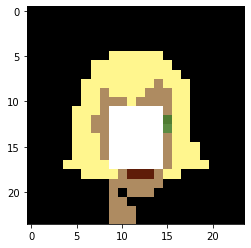

In [97]:
temp = finalArray[0,:,:,:].copy()

d2min, d2max = 9,14 
d1min, d1max = 11,17

temp[d1min:(d1max + 1), d2min:(d2max + 1)] = 255

plt.imshow(temp.astype('uint8'))

In [98]:
cancerpunks = finalArray.copy()
label = np.zeros(n)

## Loop over the cryptopunks
for i in range(10000):
  flip = np.random.randint(0, 2)
  if flip == 1:
    label[i] = 1
    d1loc = np.random.randint(d1min, d1max + 1)
    d2loc = np.random.randint(d2min, d2max + 1)
    cancerpunks[i,d1loc,d2loc,:] = 255

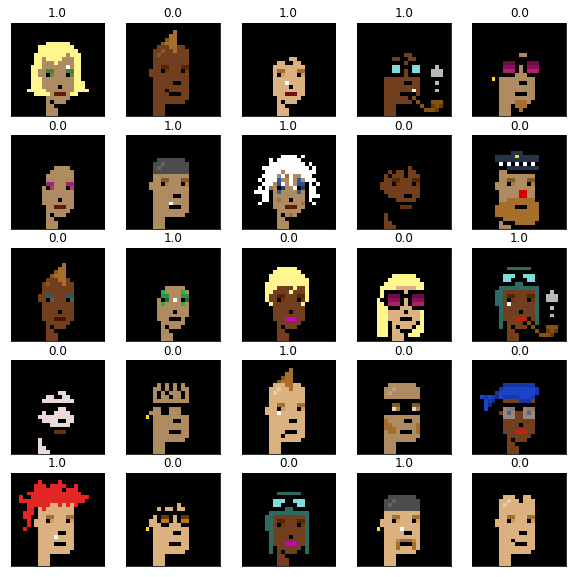

In [99]:
## plot some examples
plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(cancerpunks[i,:,:,:].astype('uint8'))
  plt.title(label[i])

In [100]:
# shape/type of features and target
print(np.shape(cancerpunks), type(cancerpunks))
print(np.shape(label), type(label))

(10000, 24, 24, 3) <class 'numpy.ndarray'>
(10000,) <class 'numpy.ndarray'>


## Data Preprocessing

Let’s normalize our array and split it into testing and training data.

In [101]:
n = cancerpunks.shape[0]
trainFraction = .75
sample = np.random.uniform(size = n) < trainFraction
x_train = cancerpunks[ sample, :, :, :] / 255
x_test =  cancerpunks[~sample, :, :, :] / 255

y_train = label[ sample,]
y_test =  label[~sample,]
## Need to have the extra dimension
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

print([x_train.shape, x_test.shape])
print([y_train.shape, y_test.shape])

[(7458, 24, 24, 3), (2542, 24, 24, 3)]
[(7458, 1), (2542, 1)]


In [102]:
# count the occurrence of 0 and 1 in our target label
unique, counts = np.unique(label, return_counts=True)
print(unique, counts)

[0. 1.] [5070 4930]


## Building the Model from Scratch

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [103]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

Let's then add a Flatten layer that flattens the input image, which then feeds into the next layer, a Dense layer, or fully-connected layer, with 128 hidden units. Finally, because our goal is to perform binary classification, our final layer will be a sigmoid, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is of class 1 (class 1 being diseased and class 0 being healthy).

In [104]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (24,24,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

The model.summary() method call prints a summary of the NN

In [105]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 1728)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               221312    
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 221,441
Trainable params: 221,441
Non-trainable params: 0
_________________________________________________________________


Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss. We will use the `Adam` optimizer. [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) is a sensible optimization algorithm because it automates learning-rate tuning for us (alternatively, we could also use [RMSProp](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) or [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad) for similar results). We will add accuracy to `metrics` so that the model will monitor accuracy during training

In [106]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

## Training

Let's train for 30 epochs. 

Notice that as we train, our validation accuracy never exceeds training accuracy, which is a good thing. Our model won't work better on unseen images than seen images.

In [107]:
history = model.fit(x_train, y_train, 
      validation_data=(x_test, y_test),
      #steps_per_epoch=8, validation_steps=8,
      epochs=30,
      verbose=1)

Epoch 1/30
234/234 [==============================] - 1s 2ms/step - loss: 0.7004 - accuracy: 0.5059 - val_loss: 0.6958 - val_accuracy: 0.5197
Epoch 2/30
234/234 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5227 - val_loss: 0.6928 - val_accuracy: 0.5173
Epoch 3/30
234/234 [==============================] - 0s 2ms/step - loss: 0.6911 - accuracy: 0.5358 - val_loss: 0.6957 - val_accuracy: 0.5271
Epoch 4/30
234/234 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5440 - val_loss: 0.7009 - val_accuracy: 0.5102
Epoch 5/30
234/234 [==============================] - 0s 2ms/step - loss: 0.6873 - accuracy: 0.5422 - val_loss: 0.6873 - val_accuracy: 0.5472
Epoch 6/30
234/234 [==============================] - 0s 2ms/step - loss: 0.6815 - accuracy: 0.5687 - val_loss: 0.6865 - val_accuracy: 0.5559
Epoch 7/30
234/234 [==============================] - 0s 2ms/step - loss: 0.6787 - accuracy: 0.5740 - val_loss: 0.6877 - val_accuracy: 0.5535
Epoch 

## Accuracy, ROC Curve, and AUC

Let's evaluate the accuracy of our model:

In [108]:
model.evaluate(x_test, y_test)

80/80 [==============================] - 0s 943us/step - loss: 0.5256 - accuracy: 0.7514


[0.5255604982376099, 0.7513768672943115]

For calculating/plotting our ROC curve, first, let's make predictions on our validation set:

In [109]:
preds = (model.predict(x_test) > 0.5).astype("int32")

To create the ROC curve and AUC, we'll need to compute the false-positive rate and the true-positive rate:

In [110]:
fpr, tpr, _ = roc_curve(y_test, preds)

roc_auc = auc(fpr, tpr)

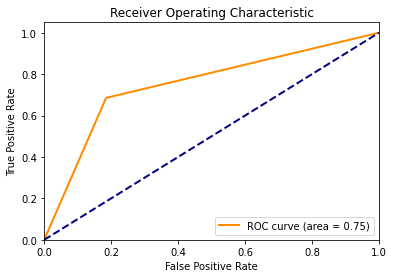

In [111]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC curve is a probability curve plotting the true-positive rate (TPR) against the false-positive rate (FPR). In this curve, the diagonal line is the curve for random guessing, e.g. coin flipping, so the ROC curve above shows that our model does better than chance at classifying between diseased or healthy punks.

Similarly, the AUC (area under curve), as shown in the legend above, measures how much our model is capable of distinguishing between our two classes. The higher the AUC, the better our model is at classification.

## Visualize algorithm's mistakes

Visualize some of your algorithm's mistakes (in both directions) and describe what is happening. In other words, consider punks declared very likely to have a cancer that did not and ones that did not have a cancer that it declared very likely that they did. Plot those. Is there a reason why it seems like it's so wrong for these cases?

Answer: First, please look at the following wrong cases, i.e., one false negative (FN) and one false positive (FP). Based on the plotted figures, there are multiple one-pixel areas in both examples, such as the eyes and nose. The intensity differences of those one-pixel areas with the skin tone of these punks could be one reason for these mistakes. The more significant this difference, the greater the likelihood of false positive, and the lower this difference, the lower the possibility of false negative.

### False negative (FN) example: Very likely to have a cancer that did not

Text(0.5, 1.0, 'Observed label: 1 \nPredicted label: 0')

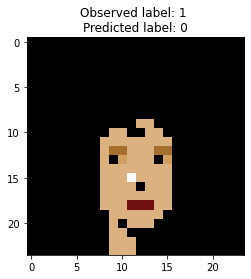

In [138]:
idx_fn = 0 # index of a FN example

plt.imshow(x_test[idx_fn,:,:,:])
plt.title("Observed label: {t} \nPredicted label: {p}".format(t=int(y_test[idx_fn]), p=int(preds[idx_fn])))

### False positive (FP) example: Ones that did not have a cancer that it declared very likely that they did

Text(0.5, 1.0, 'Observed label: 0 \nPredicted label: 1')

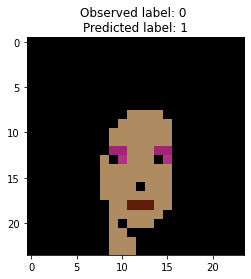

In [136]:
idx_fp = 1 # index of a FP example

plt.imshow(x_test[idx_fp,:,:,:])
plt.title("Observed label: {t} \nPredicted label: {p}".format(t=int(y_test[idx_fp]), p=int(preds[idx_fp])))

## Predict new image (new cancerpunks)

Create a python function that takes in an np image array just like the cancerpunks one below and gives probabilities that that punk has this disease.

Let's first create the cancerpunks as below:

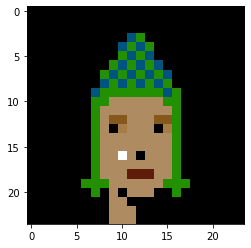

In [155]:
new_image = finalArray[100,:,:,:].copy()

d2min, d2max = 10,10 
d1min, d1max = 16,16

new_image[d1min:(d1max + 1), d2min:(d2max + 1)] = 255

plt.imshow(new_image.astype('uint8'))

Now, predict and calculate the probabilities that that punk has this disease:

In [156]:
new_image = np.expand_dims(new_image,axis=0)

model.predict(new_image)

array([[1.]], dtype=float32)